<a href="https://colab.research.google.com/github/owen198/csc_domain_adaptation/blob/main/csc_autoencoder_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import losses

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Load data and preprocess

1.   Load data
2.   Divide into normal, abnormal and repaired
3.   



In [3]:
tag1 = 'W4662FM0507'
tag2 = 'W4662FM0606'
path = './gdrive/My Drive/data/CSC/W4/'

In [4]:
tag1_pd = pd.concat([pd.read_csv(path+tag1+'_202009.csv'),
                       pd.read_csv(path+tag1+'_202010.csv'),
                       pd.read_csv(path+tag1+'_202011.csv'),
                       pd.read_csv(path+tag1+'_202012.csv'),
                       pd.read_csv(path+tag1+'_202101.csv'),
                       pd.read_csv(path+tag2+'_202101.csv'),
                       pd.read_csv(path+tag2+'_202102.csv')])

tag2_pd = pd.concat([pd.read_csv(path+tag2+'_202009.csv'),
                       pd.read_csv(path+tag2+'_202010.csv'),
                       pd.read_csv(path+tag2+'_202011.csv'),
                       pd.read_csv(path+tag2+'_202012.csv'),
                       pd.read_csv(path+tag2+'_202101.csv'),
                       pd.read_csv(path+tag2+'_202102.csv')])

In [5]:
tag1_pd['datetime'] = tag1_pd['timestamp'].astype('int').astype("datetime64[s]")
tag2_pd['datetime'] = tag2_pd['timestamp'].astype('int').astype("datetime64[s]")

In [6]:
tag1_normal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2021,1,8,0,0))]
tag1_abnormal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2021,1,9,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

tag2_normal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,1,8,0,0))]
tag2_abnormal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2021,1,9,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

In [7]:
#list(target_repaired)

tag1_normal_dt = tag1_normal['datetime']
tag1_abnormal_dt = tag1_abnormal['datetime']

tag2_normal_dt = tag2_normal['datetime']
tag2_abnormal_dt = tag2_abnormal['datetime']

original_list = [s for s in list(tag1_normal) if (s.startswith('CREST') or 
                                                      s.startswith('KURT_') or 
                                                      s.startswith('SKEW') or 
                                                      s.startswith('RMS_'))]

tag1_normal = tag1_normal[original_list]
tag1_abnormal = tag1_abnormal[original_list]

tag2_normal = tag2_normal[original_list]
tag2_abnormal = tag2_abnormal[original_list]

In [8]:
'''
drop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']

source_normal = source_normal.drop(columns=drop_list)
source_abnormal = source_abnormal.drop(columns=drop_list)
source_repaired = source_repaired.drop(columns=drop_list)

target_normal = target_normal.drop(columns=drop_list)
target_abnormal = target_abnormal.drop(columns=drop_list)
target_repaired = target_repaired.drop(columns=drop_list)
'''


"\ndrop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']\n\nsource_normal = source_normal.drop(columns=drop_list)\nsource_abnormal = source_abnormal.drop(columns=drop_list)\nsource_repaired = source_repaired.drop(columns=drop_list)\n\ntarget_normal = target_normal.drop(columns=drop_list)\ntarget_abnormal = target_abnormal.drop(columns=drop_list)\ntarget_repaired = target_repaired.drop(columns=drop_list)\n"

# Define Target and Source

In [9]:
import random

shape_min = min (tag1_normal.shape[0], tag2_normal.shape[0])
shape_max = max (tag1_normal.shape[0], tag2_normal.shape[0])

index = sorted(random.sample(range(0, shape_max), shape_min))

In [10]:
X_source = tag1_normal
X_target = tag2_normal

X_source_ab = tag1_abnormal
X_target_ab = tag2_abnormal

X_source_dt = tag1_normal_dt
X_target_dt = tag2_normal_dt

X_source_ab_dt = tag1_abnormal_dt
X_target_ab_dt = tag2_abnormal_dt

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_source)

X_source = pd.DataFrame(min_max_scaler.transform(X_source))
X_target = pd.DataFrame(min_max_scaler.transform(X_target))

X_source_ab = pd.DataFrame(min_max_scaler.transform(X_source_ab))
X_target_ab = pd.DataFrame(min_max_scaler.transform(X_target_ab))

#target_normal = pd.DataFrame(min_max_scaler.transform(target_normal))
#target_abnormal = pd.DataFrame(min_max_scaler.transform(target_abnormal))

# OneClass SVM cross-validation

In [12]:
model_source = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_source)
model_target = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_target)

In [13]:
def scorer_(Y_pred):
    a = (Y_pred[Y_pred == -1].size)/(Y_pred.size)
    return a*100

In [14]:
def plot_score (score_list, date_list, tag):

    fig, ax = plt.subplots(figsize=(10, 2))
    plt.xticks(rotation=45)
    ax.plot(date_list, score_list, 'o-')
    ax.set(xlabel='date', ylabel='score', title=tag)
    ax.grid()
    #fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
    plt.show()

In [15]:
def get_score_list(normal_df, abnormal_df, normal_df_dt, abnormal_df_dt, model):

    score_list = []
    date_list = []
    delta = datetime.timedelta(days=1)

    validation_df = normal_df.append(abnormal_df)
    validation_df_dt = normal_df_dt.append(abnormal_df_dt)
    validation_df['datetime'] = validation_df_dt.values

    # calculation duration
    start_date = validation_df.head(1)['datetime'].values[0]
    end_date = validation_df.tail(1)['datetime'].values[0]
    start_date = datetime.datetime.fromtimestamp(start_date.astype('datetime64[s]').astype('int'))
    end_date = datetime.datetime.fromtimestamp(end_date.astype('datetime64[s]').astype('int'))
    
    while start_date <= end_date:
        validation_sub_df = validation_df[(validation_df['datetime'] > start_date) & (validation_df['datetime'] < start_date + delta)]

        if len(validation_sub_df) > 0:

            validation_df_sc = model.predict(validation_sub_df.drop(columns=['datetime']))
            score_list.append(scorer_(validation_df_sc))
            date_list.append(start_date)

        start_date += delta
        
    return score_list, date_list

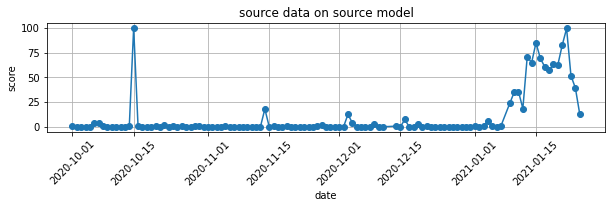

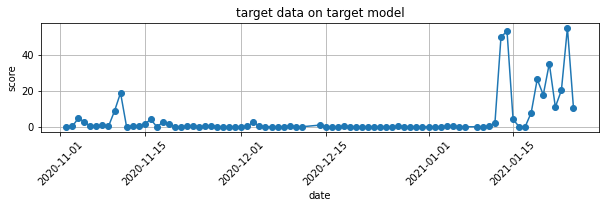

In [16]:
source_score, source_date = get_score_list(X_source, 
                                           X_source_ab, 
                                           X_source_dt, 
                                           X_source_ab_dt, 
                                           model_source)

plot_score (source_score, source_date, 'source data on source model')

target_score, target_date = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_target)

plot_score (target_score, target_date, 'target data on target model')

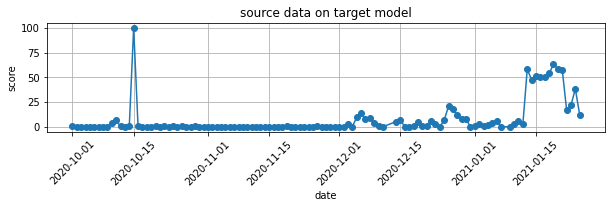

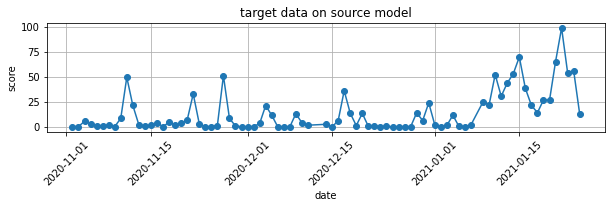

In [17]:
source_score_cv, source_date_cv = get_score_list(X_source, 
                                           X_source_ab, 
                                           X_source_dt, 
                                           X_source_ab_dt,  
                                           model_target)

plot_score (source_score_cv, source_date_cv, 'source data on target model')

target_score_cv, target_date_cv = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_source)

plot_score (target_score_cv, target_date_cv, 'target data on source model')

## Autoencoder

In [18]:
bottleneck_dim = 16
input_dim = X_source.shape[1]
encoder_dim_1 = 512
encoder_dim_2 = 256
encoder_dim_3 = 128
encoder_dim_4 = 64
encoder_dim_5 = 32
decoder_dim_1 = 32
decoder_dim_2 = 64
decoder_dim_3 = 128
decoder_dim_4 = 256
decoder_dim_5 = 512

# 定義 autoencoder 模型
input_img = Input(shape=(input_dim,))
x = Dense(encoder_dim_1, activation="relu")(input_img)
x = Dense(encoder_dim_2, activation="relu")(x)
x = Dense(encoder_dim_3, activation="relu")(x)
x = Dense(encoder_dim_4, activation="relu")(x)
x = Dense(encoder_dim_5, activation="relu")(x)

encoded = Dense(bottleneck_dim, activation="relu")(x)
x = Dense(decoder_dim_1, activation="relu")(encoded)
x = Dense(decoder_dim_2, activation="relu")(x)
x = Dense(decoder_dim_3, activation="relu")(x)
x = Dense(decoder_dim_4, activation="relu")(x)
x = Dense(decoder_dim_5, activation="relu")(x)
decoded = Dense(input_dim, activation="sigmoid")(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()  # 顯示模型摘要資訊

# 定義 encoder 模型
encoder = Model(input_img, encoded)
#encoder.summary()    # 顯示模型摘要資訊

# 定義 decoder 模型
decoder_input = Input(shape=(bottleneck_dim,))
decoder_layer = autoencoder.layers[-6](decoder_input)
decoder_layer = autoencoder.layers[-5](decoder_layer)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input, decoder_layer)
#decoder.summary()    # 顯示模型摘要資訊

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               53760     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528   

In [19]:
print(X_target.shape)
print(X_source.shape)

(44221, 104)
(61255, 104)


In [20]:
if len(X_target) > len(X_source):
    X = X_target.iloc[index]
    Y = X_source
else:
    X = X_target
    Y = X_source.iloc[index]

In [21]:
opt=optimizers.Adam(lr=0.000001)



autoencoder.compile(loss=losses.mean_squared_error, 
                    optimizer='Adam')


early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=2)
# 訓練模型
model = autoencoder.fit(X, 
                        Y,
                        validation_split=0.2,
                        epochs=200, 
                        batch_size=256, 
                        callbacks = early_stopping,
                        verbose=1)

encoded_imgs = encoder.predict(X_source)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/200
139/139 [==============================] - 4s 26ms/step - loss: 0.0337 - val_loss: 0.0102
Epoch 2/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 3/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0075 - val_loss: 0.0114
Epoch 4/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 5/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0062 - val_loss: 0.0107
Epoch 6/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0062 - val_loss: 0.0123
Epoch 7/200
139/139 [==============================] - 3s 21ms/step - loss: 0.0061 - val_loss: 0.0115
Epoch 8/200
139/139 [==============================] - 3s 22ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 9/200
139/139 [==============================] - 3s 21ms/step - loss: 0.0059 - val_loss: 0.0130
Epoch 10/200
139/139 [==============================] - 3s 21ms/step - loss: 0.005

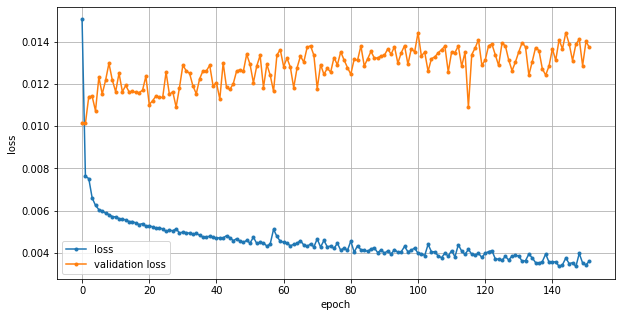

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(model.history['loss'], marker='.', label='loss')
ax.plot(model.history['val_loss'], marker='.', label='validation loss')

ax.legend()
ax.grid(True)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('epoches.png', dpi=300)
plt.show()

#model.history.keys()

In [23]:
#print('original dist:', np.linalg.norm(X_source-X_target.sample(n=15017)))
#print('domain adaptation:', np.linalg.norm(decoded_imgs - X_target.sample(n=15017)))

In [24]:
from sklearn.decomposition import PCA

pca_scale = PCA(n_components=2)
pca_scale = pca_scale.fit(X_source)

X_source_dr = pca_scale.transform(X_source)
x_min, x_max = X_source_dr.min(0), X_source_dr.max(0)
X_norm = (X_source_dr-x_min) / (x_max-x_min)  #Normalize
X_source_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_target_dr = pca_scale.transform(X_target)
x_min, x_max = X_target_dr.min(0), X_target_dr.max(0)
X_norm = (X_target_dr-x_min) / (x_max-x_min)  #Normalize
X_target_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_decoder_dr = pca_scale.transform(decoded_imgs)
x_min, x_max = X_decoder_dr.min(0), X_decoder_dr.max(0)
X_norm = (X_decoder_dr-x_min) / (x_max-x_min)  #Normalize
X_decode_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

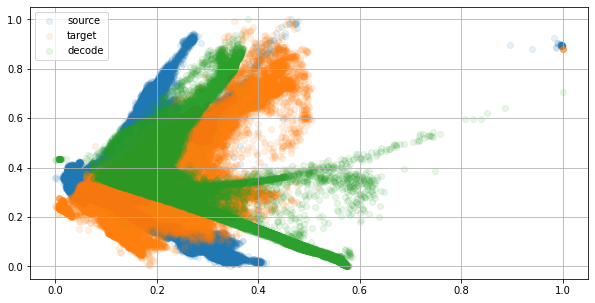

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(X_source_df['dim1'], X_source_df['dim2'], alpha=0.1, label='source')
ax.scatter(X_target_df['dim1'], X_target_df['dim2'], alpha=0.1, label='target')
ax.scatter(X_decode_df['dim1'], X_decode_df['dim2'], alpha=0.1, label='decode')

ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.savefig('distribution.png', dpi=300)
plt.show()

In [26]:
source_encode = encoder.predict(X_source)
target_encode = encoder.predict(X_target)

target_decode = decoder.predict(target_encode)
source_decode = decoder.predict(source_encode)

In [27]:
# test bottleneck layer

model_encode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(target_encode)

pred_source = scorer_(model_encode.predict(source_encode))
pred_target = scorer_(model_encode.predict(target_encode))

print('source:', pred_source, 'target:', pred_target)

source: 0.0816259897151253 target: 1.0017864815359219


In [28]:
# test decode layer
model_decode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(source_decode)

pred_source = scorer_(model_decode.predict(source_decode))
pred_target = scorer_(model_decode.predict(target_decode))

print('source:', pred_source, 'target:', pred_target)

source: 0.9974695943188311 target: 13.737816874335723


In [29]:
# test target model

pred_target_by_target = scorer_(model_target.predict(X_target))
pred_target_by_source = scorer_(model_decode.predict(X_target))
print('without any intervention:', pred_target_by_target, pred_target_by_source)

without any intervention: 1.0017864815359219 71.95450125505981


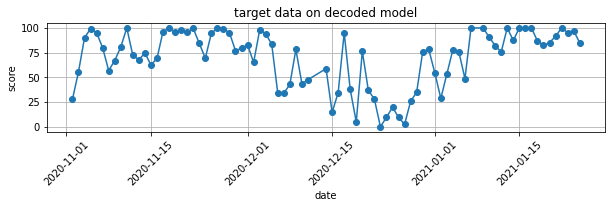

In [30]:
target_score_da, target_date_da = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_decode)

plot_score (target_score_da, target_date_da, 'target data on decoded model')

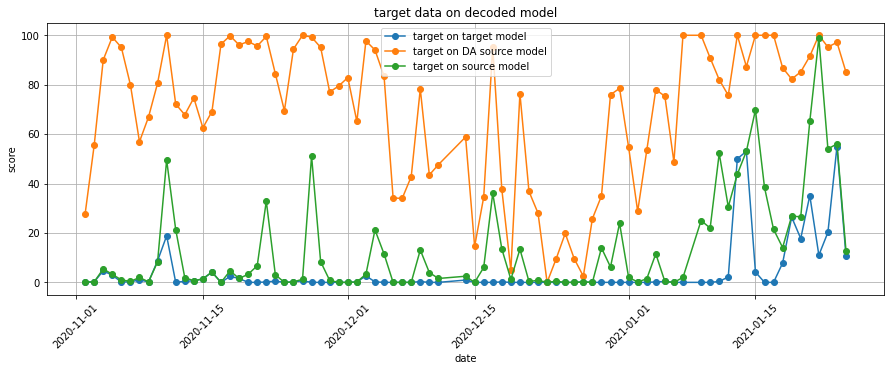

In [31]:

fig, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation=45)
ax.plot(target_date, target_score, 'o-', label='target on target model')
ax.plot(target_date_da, target_score_da, 'o-', label='target on DA source model')
ax.plot(target_date_cv, target_score_cv, 'o-', label='target on source model')

ax.set(xlabel='date', ylabel='score', title='target data on decoded model')

ax.legend()
ax.grid()
#fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
plt.show()